## Homework #5. Behaviour exploration improvement
#### Author: `Markiian Mandzak`
#### Total time spent on h/w (in minutes): ~360min

# 0. Setup

## 0.1. Imports

In [1]:
import json
import os
import re
import string
from collections import Counter

import altair as alt
import hdbscan
import langcodes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from imblearn.under_sampling import RandomUnderSampler
from langid.langid import LanguageIdentifier, model as lang_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
import gender_guesser.detector as gender

alt.data_transformers.disable_max_rows()

/Users/markson/Desktop/UCU/UCU_6K1S_ComputationalSocialSciences/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DataTransformerRegistry.enable('default')

## 0.2. Constants

In [2]:
DIALOGS_MERGED_DATA_PATH = "../data_personal/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../data_personal/merged_data/dialogs_users_all.csv"
DICTS_DIR = "tone-dict-ukrainian/dicts"
MY_UID = 540076029

## 0.3. Stopwords

In [3]:
# https://github.com/skupriienko/Ukrainian-Stopwords/blob/master/stopwords_ua_set.txt
uk_stopwords = {'а', 'аби', 'абиде', 'абиким', 'абикого', 'абиколи', 'абикому', 'абикуди', 'абихто', 'абичий', 'абичийого', 'абичийому', 'абичим', 'абичию', 'абичия', 'абичиє', 'абичиєму', 'абичиєю', 'абичиєї', 'абичиї', 'абичиїй', 'абичиїм', 'абичиїми', 'абичиїх', 'абичого', 'абичому', 'абищо', 'абияка', 'абияке', 'абиякий', 'абияким', 'абиякими', 'абияких', 'абиякого', 'абиякому', 'абиякою', 'абиякої', 'абияку', 'абиякі', 'абиякій', 'абиякім', 'або', 'абощо', 'авжеж', 'авось', 'ага', 'ад', 'адже', 'аж', 'ажень', 'аз', 'ай', 'але', 'ало', 'амінь', 'ант', 'ану', 'ані', 'аніде', 'аніж', 'анізащо', 'аніким', 'анікого', 'анікогісінько', 'аніколи', 'анікому', 'аніскільки', 'аніхто', 'анічим', 'анічого', 'анічогісінько', 'анічому', 'аніщо', 'аніяка', 'аніяке', 'аніякий', 'аніяким', 'аніякими', 'аніяких', 'аніякого', 'аніякому', 'аніякою', 'аніякої', 'аніяку', 'аніякі', 'аніякій', 'аніякім', 'аніякісенька', 'аніякісеньке', 'аніякісенький', 'аніякісеньким', 'аніякісенькими', 'аніякісеньких', 'аніякісенького', 'аніякісенькому', 'аніякісенькою', 'аніякісенької', 'аніякісеньку', 'аніякісенькі', 'аніякісенькій', 'аніякісенькім', 'аніякісінька', 'аніякісіньке', 'аніякісінький', 'аніякісіньким', 'аніякісінькими', 'аніякісіньких', 'аніякісінького', 'аніякісінькому', 'аніякісінькою', 'аніякісінької', 'аніякісіньку', 'аніякісінькі', 'аніякісінькій', 'аніякісінькім', 'ат', 'ато', 'атож', 'ау', 'ах', 'ач', 'ачей', 'аякже', 'б', 'ба', 'багато', 'багатьма', 'багатьом', 'багатьох', 'баз', 'бай', 'бат', 'бах', 'бац', 'баш', 'бе', 'беж', 'без', 'безперервно', 'бел', 'бер', 'би', 'бир', 'бич', 'близько', 'близько від', 'бо', 'бов', 'бод', 'бодай', 'боз', 'бош', 'був', 'буває', 'буде', 'будем', 'будемо', 'будете', 'будеш', 'буду', 'будуть', 'будь', 'будь ласка', 'будьмо', 'будьте', 'була', 'були', 'було', 'бути', 'бух', 'буц', 'буцім', 'буцімто', 'бі', 'біб', 'більш', 'більше', 'біля', 'в', 'в бік', 'в залежності від', 'в міру', 'в напрямі до', 'в порівнянні з', 'в процесі', 'в результаті', 'в ролі', 'в силу', 'в сторону', 'в супроводі', 'в ході', "в ім'я", 'в інтересах', 'вад', 'важлива', 'важливе', 'важливий', 'важливі', 'вак', 'вам', 'вами', 'ван', 'вас', 'ват', 'ваш', 'ваша', 'ваше', 'вашим', 'вашими', 'ваших', 'вашого', 'вашому', 'вашою', 'вашої', 'вашу', 'ваші', 'вашій', 'вашім', 'ввесь', 'вві', 'вгору', 'вдалині', 'вед', 'верх', 'весь', 'вех', 'вже', 'вздовж', 'ви', 'виз', 'вис', 'височині', 'вище ', 'вйо', 'власне', 'властиво', 'вміти', 'внаслідок', 'вниз', 'внизу', 'во', 'вон', 'вона', 'вони', 'воно', 'восьмий', 'вперед', 'вподовж', 'впоперек', 'впритиск', 'впритул', 'впродовж', 'впрост', 'все', 'всередині', 'всею', 'вслід', 'всупереч', 'всього', 'всьому', 'всю', 'всюди', 'вся', 'всяк', 'всяка', 'всяке', 'всякий', 'всяким', 'всякими', 'всяких', 'всякого', 'всякому', 'всякою', 'всякої', 'всяку', 'всякі', 'всякій', 'всякім', 'всі', 'всій', 'всіляка', 'всіляке', 'всілякий', 'всіляким', 'всілякими', 'всіляких', 'всілякого', 'всілякому', 'всілякою', 'всілякої', 'всіляку', 'всілякі', 'всілякій', 'всілякім', 'всім', 'всіма', 'всіх', 'всією', 'всієї', 'втім', 'ві', 'віг', 'від', 'від імені', 'віддалік від', 'відколи', 'відносно', 'відповідно', 'відповідно до', 'відсотків', 'відтепер', 'відтоді', 'він', 'вісім', 'вісімнадцятий', 'вісімнадцять', 'віт', 'віф', 'віх', 'віц', 'віщо', 'віщось', 'г', 'га', 'гав', 'гаразд', 'ге', 'гез', 'гем', 'геп', 'гет', 'геть', 'гех', 'ги', 'гик', 'гир', 'гич', 'гм', 'го', 'говорив', 'гог', 'гоп', 'гоц', 'гу', 'гуп', 'д', 'да', 'давай', 'давати', 'давно', 'далеко', 'далеко від', 'далі', 'даром', 'два', 'двадцятий', 'двадцять', 'дванадцятий', 'дванадцять', 'двох', 'дві', 'де', "дев'ятий", "дев'ятнадцятий", "дев'ятнадцять", "дев'ять", 'дедалі', 'деким', 'декого', 'деколи', 'декому', 'декотра', 'декотре', 'декотрий', 'декотрим', 'декотрими', 'декотрих', 'декотрого', 'декотрому', 'декотрою', 'декотрої', 'декотру', 'декотрі', 'декотрій', 'декотрім', 'декілька', 'декільком', 'декількома', 'декількох', 'декім', 'десь', 'десятий', 'десять', 'дехто', 'дечий', 'дечийого', 'дечийому', 'дечим', 'дечию', 'дечия', 'дечиє', 'дечиєму', 'дечиєю', 'дечиєї', 'дечиї', 'дечиїй', 'дечиїм', 'дечиїми', 'дечиїх', 'дечого', 'дечому', 'дечім', 'дещо', 'деяка', 'деяке', 'деякий', 'деяким', 'деякими', 'деяких', 'деякого', 'деякому', 'деякою', 'деякої', 'деяку', 'деякі', 'деякій', 'деякім', 'деінде', 'для', 'до', 'добре', 'довго', 'довкола', 'довкіл', 'дог', 'доки', 'допоки', 'допіру', 'досить', 'досі', 'дотепер', 'доти', 'другий', 'друго', 'дуже', 'дякую', 'дійсно', 'діл', 'е', 'еге', 'еж', 'ей', 'ерг', 'ест', 'ет', 'ех', 'еч', 'ж', 'же', 'жоден', 'жодна', 'жодне', 'жодний', 'жодним', 'жодними', 'жодних', 'жодного', 'жодному', 'жодною', 'жодної', 'жодну', 'жодні', 'жодній', 'жоднім', 'жоднісінька', 'жоднісіньке', 'жоднісінький', 'жоднісіньким', 'жоднісінькими', 'жоднісіньких', 'жоднісінького', 'жоднісінькому', 'жоднісінькою', 'жоднісінької', 'жоднісіньку', 'жоднісінькі', 'жоднісінькій', 'жоднісінькім', 'жуз', 'з', 'з метою', 'з нагоди', 'з приводу', 'з розрахунку на', 'з-за', 'з-над', 'з-перед', 'з-поза', 'з-поміж', 'з-понад', 'з-поперед', 'з-посеред', 'з-проміж', 'з-під', 'з-серед', 'за', 'за винятком', 'за допомогою', 'за посередництвом', 'за рахунок', 'завгодно', 'завдяки', 'завжди', 'завше', 'задля', 'зазвичай', 'зайнята', 'зайнятий', 'зайнято', 'зайняті', 'залежно', 'залежно від', 'замість', 'занадто', 'заради', 'зараз', 'зас', 'зате', 'збоку', 'збоку від', 'зважаючи на', 'зверх ', 'зверху', 'звичайно', 'звиш', 'звідки', 'звідкилясь', 'звідкись', 'звідкіль', 'звідкіля', 'звідкілясь', 'звідси', 'звідсіль', 'звідсіля', 'звідти', 'звідтіль', 'звідтіля', 'звідусюди', 'звідусіль', 'звідціля', 'згідно з', 'здається', 'здовж', 'зем', 'зет', 'ззаду', 'зиз', 'зик', 'значить', 'знову', 'зо', 'зовсім', 'зсередини', 'зух', 'зі', 'зіс', 'и', 'ич', 'й', 'ймовірно', 'йно', 'йо', 'його', 'йой', 'йол', 'йому', 'йор', 'йот', 'йох', 'к', 'каже', 'каз', 'кар', 'каф', 'ках', 'ке', 'кед', 'кет', 'кеш', 'кив', 'кий', 'кил', 'ким', 'кимось', 'кимсь', 'ких', 'киш', 'коб', 'коби', 'кого', 'когось', 'кожен', 'кожна', 'кожне', 'кожний', 'кожним', 'кожними', 'кожних', 'кожного', 'кожному', 'кожною', 'кожної', 'кожну', 'кожні', 'кожній', 'кожнім', 'кожнісінька', 'кожнісіньке', 'кожнісінький', 'кожнісіньким', 'кожнісінькими', 'кожнісіньких', 'кожнісінького', 'кожнісінькому', 'кожнісінькою', 'кожнісінької', 'кожнісіньку', 'кожнісінькі', 'кожнісінькій', 'кожнісінькім', 'коли', 'колись', 'коло', 'кому', 'комусь', 'котра', 'котрась', 'котре', 'котресь', 'котрий', 'котрийсь', 'котрим', 'котрими', 'котримись', 'котримось', 'котримсь', 'котрих', 'котрихось', 'котрихсь', 'котрого', 'котрогось', 'котрому', 'котромусь', 'котрою', 'котроюсь', 'котрої', 'котроїсь', 'котру', 'котрусь', 'котрі', 'котрій', 'котрійсь', 'котрім', 'котрімсь', 'котрісь', 'коц', 'коч', 'коштом', 'край', 'краще', 'кру', 'круг', 'кругом', 'крю', 'кря', 'крізь', 'крім', 'куди', 'кудись', 'кудою', 'кілька', 'кільком', 'кількома', 'кількох', 'кім', 'кімось', 'кімсь', 'кінець', 'л', 'лаж', 'лап', 'лас', 'лат', 'ле', 'ледве', 'ледь', 'лет', 'лиш', 'лише', 'лишень', 'лум', 'луп', 'лут', 'льє', 'люди', 'людина', 'ля', 'лі', 'ліворуч від', 'лік', 'лім', 'м', 'мабуть', 'майже', 'мало', 'мати', 'мац', 'ме', 'меж', 'мене', 'менше', 'мені', 'мерсі', 'мет', 'мжа', 'ми', 'мимо ', 'миру', 'мит', 'мною', 'мо', 'мов', 'мовби', 'мовбито', 'могла', 'могли', 'могло', 'мого', 'могти', 'мож', 'може', 'можем', 'можемо', 'можете', 'можеш', 'можна', 'можу', 'можуть', 'можіть', 'мой', 'мол', 'мою', 'моя', 'моє', 'моєму', 'моєю', 'моєї', 'мої', 'моїй', 'моїм', 'моїми', 'моїх', 'му', 'мі', 'міг', 'між', 'мій', 'мільйонів', 'н', 'на', 'на адресу', 'на базі', 'на благо', 'на випадок', 'на відміну від', 'на засадах', 'на знак', 'на зразок', 'на користь', 'на кшталт', 'на межі', 'на основі', 'на противагу', 'на підставі', 'на честь', 'на чолі', 'на ґрунті', 'навколо', 'навкруг', 'навкруги ', 'навкіл', 'навпаки', 'навперейми', 'навпроти', 'навіть', 'навіщо', 'навіщось', 'нагорі', 'над', 'надо', 'надовкола', 'надокола', 'наді', 'назавжди', 'назад', 'назустріч', 'най', 'найбільш', 'нам', 'нами', 'наоколо ', 'наокруг ', 'наокруги ', 'наокіл', 'наперед', 'напередодні', 'напереді', 'наперекір', 'напереріз', 'наприкінці', 'напроти', 'нарешті', 'нарівні з', 'нас', 'насеред', 'насподі', 'наспід', 'настрічу', 'насупроти', 'насупротив ', 'нате', 'наче', 'начеб', 'начебто', 'наш', 'наша', 'наше', 'нашим', 'нашими', 'наших', 'нашого', 'нашому', 'нашою', 'нашої', 'нашу', 'наші', 'нашій', 'нашім', 'не', 'не до', 'не можна', 'неабичим', 'неабичого', 'неабичому', 'неабищо', 'небагато', 'небагатьма', 'небагатьом', 'небагатьох', 'небудь', 'невважаючи', 'невже', 'недалеко', 'недалеко від', 'неж', 'незалежно від', 'незважаючи', 'незважаючи на', 'ней', 'немає', 'немов', 'немовби', 'немовбито', 'неначе', 'неначебто', 'неподалеку', 'неподалеку від', 'неподалечку', 'неподалечку від', 'неподалік', 'неподалік від', 'нерідко', 'нех', 'нехай', 'нещодавно', 'нею', 'неї', 'нижче', 'низько', 'ник', 'ним', 'ними', 'них', 'нич', 'но', 'ну', 'нуг', 'нуд', 'нум', 'нумо', 'нумте', 'ньо', 'нього', 'ньому', 'ню', 'нюх', 'ня', 'няв', 'ні', 'ніби', 'ніби-то', 'нібито', 'ніде', 'ніж', 'нізащо', 'нізвідки', 'нізвідкіля', 'ній', 'ніким', 'нікого', 'нікогісінько', 'ніколи', 'нікому', 'нікотра', 'нікотре', 'нікотрий', 'нікотрим', 'нікотрими', 'нікотрих', 'нікотрого', 'нікотрому', 'нікотрою', 'нікотрої', 'нікотру', 'нікотрі', 'нікотрій', 'нікотрім', 'нікуди', 'нім', 'нінащо', 'ніскільки', 'ніт', 'ніхто', 'нічий', 'нічийна', 'нічийне', 'нічийний', 'нічийним', 'нічийними', 'нічийних', 'нічийного', 'нічийному', 'нічийною', 'нічийної', 'нічийну', 'нічийні', 'нічийній', 'нічийнім', 'нічийого', 'нічийому', 'нічим', 'нічию', 'нічия', 'нічиє', 'нічиєму', 'нічиєю', 'нічиєї', 'нічиї', 'нічиїй', 'нічиїм', 'нічиїми', 'нічиїх', 'нічого', 'нічому', 'ніщо', 'ніяк', 'ніяка', 'ніяке', 'ніякий', 'ніяким', 'ніякими', 'ніяких', 'ніякого', 'ніякому', 'ніякою', 'ніякої', 'ніяку', 'ніякі', 'ніякій', 'ніякім', 'ніякісінька', 'ніякісіньке', 'ніякісінький', 'ніякісіньким', 'ніякісінькими', 'ніякісіньких', 'ніякісінького', 'ніякісінькому', 'ніякісінькою', 'ніякісінької', 'ніякісіньку', 'ніякісінькі', 'ніякісінькій', 'ніякісінькім', 'о', 'об', 'обабіч', 'обаполи', 'обидва', 'обр', 'обік', 'обіруч', 'обіч', 'ов', 'од', 'один', 'одинадцятий', 'одинадцять', 'одна', 'однак', 'одначе', 'одне', 'одним', 'одними', 'одних', 'одно', 'одного', 'одного разу', 'одному', 'одною', 'одної', 'одну', 'одні', 'одній', 'однім', 'однією', 'однієї', 'ож', 'ой', 'окрай', 'окроме', 'округ', 'округи', 'окрім', 'окіл', 'ом', 'он', 'онде', 'онно', 'оно', 'оподаль', 'оподаль від', 'оподалік', 'оподалік від', 'опостін', 'опостінь', 'опроче', 'опріч', 'опріче', 'опісля', 'осе', 'оскільки', 'особливо', 'осторонь', 'ось', 'осісьо', 'от', 'ота', 'отак', 'отака', 'отаке', 'отакий', 'отаким', 'отакими', 'отаких', 'отакого', 'отакому', 'отакою', 'отакої', 'отаку', 'отакі', 'отакій', 'отакім', 'отакісінька', 'отакісіньке', 'отакісінький', 'отакісіньким', 'отакісінькими', 'отакісіньких', 'отакісінького', 'отакісінькому', 'отакісінькою', 'отакісінької', 'отакісіньку', 'отакісінькі', 'отакісінькій', 'отакісінькім', 'отам', 'оте', 'отже', 'отим', 'отими', 'отих', 'ото', 'отого', 'отож', 'отой', 'отому', 'отою', 'отої', 'отсе', 'оттак', 'отто', 'оту', 'отут', 'оті', 'отій', 'отім', 'отією', 'отієї', 'ох', 'оце', 'оцей', 'оцим', 'оцими', 'оцих', 'оцього', 'оцьому', 'оцю', 'оця', 'оці', 'оцій', 'оцім', 'оцією', 'оцієї', 'п', "п'я", "п'ятий", "п'ятнадцятий", "п'ятнадцять", "п'ять", 'па', 'пад', 'пак', 'пек', 'перед', 'передо', 'переді', 'перетака', 'перетаке', 'перетакий', 'перетаким', 'перетакими', 'перетаких', 'перетакого', 'перетакому', 'перетакою', 'перетакої', 'перетаку', 'перетакі', 'перетакій', 'перетакім', 'перший', 'пиж', 'плі', 'по', 'поблизу', 'побік', 'побіля', 'побіч', 'поверх', 'повз', 'повздовж', 'повинно', 'повище', 'повсюди', 'повсюдно', 'подаль від', 'подалі від', 'подекуди', 'подеяка', 'подеяке', 'подеякий', 'подеяким', 'подеякими', 'подеяких', 'подеякого', 'подеякому', 'подеякою', 'подеякої', 'подеяку', 'подеякі', 'подеякій', 'подеякім', 'подовж', 'подібно до', 'поз', 'поза', 'позад', 'позаду', 'позата', 'позате', 'позатим', 'позатими', 'позатих', 'позатого', 'позатой', 'позатому', 'позатою', 'позатої', 'позату', 'позаті', 'позатій', 'позатім', 'позатією', 'позатієї', 'позаяк', 'поздовж', 'поки', 'покрай', 'покіль', 'помежи', 'помимо', 'поміж', 'помість', 'понад', 'понадо', 'понаді', 'понижче', 'пообіч', 'поодаль від', 'поодалік від', 'поперед', 'попереду', 'поперек', 'попліч', 'попри', 'попросту', 'попід', 'пора', 'поруч', 'поряд', 'поряд з', 'порівняно з', 'посеред', 'посередині', 'потрібно', 'потім', 'поуз', 'початку', 'почерез', 'праворуч від', 'пред', 'предо', 'преді', 'прекрасно', 'прецінь', 'при', 'притому', 'причому', 'причім', 'про', 'проз', 'промеж', 'проміж', 'просто', 'проте', 'проти', 'против', 'противно', 'протягом', 'пря', 'пріч', 'пхе', 'пху', 'пі', 'пів', 'півперек', 'під', 'під знаком', 'під приводом', 'під час', 'підо', 'пізніше', 'пім', 'пір', 'після', 'р', 'ради', 'раз', 'разом з', 'разу', 'рано', 'раніш', 'раніш від', 'раніше', 'раніше від', 'раптом', 'ре', 'рет', 'риж', 'рим', 'рип', 'роб', 'року', 'років', 'рос', 'рох', 'році', 'рус', 'рух', 'руч', 'рік', 'с', 'саж', 'саз', 'сак', 'сам', 'сама', 'саме', 'сами', 'самий', 'самим', 'самими', 'самих', 'само', 'самого', 'самому', 'самою', 'самої', 'саму', 'самі', 'самій', 'самім', 'сап', 'сас', 'свого', 'свою', 'своя', 'своє', 'своєму', 'своєю', 'своєї', 'свої', 'своїй', 'своїм', 'своїми', 'своїх', 'свій', 'се', 'себе', 'себто', 'сей', 'сен', 'серед', 'середи', 'середу', 'сеч', 'си', 'сив', 'сиг', 'сиз', 'сик', 'сиріч', 'сих', 'сказав', 'сказала', 'сказати', 'скрізь', 'скільки', 'скільки-то', 'скількись', 'скільком', 'скількома', 'скількомась', 'скількомось', 'скількомсь', 'скількох', 'скількохось', 'скількохсь', 'сли', 'слідом за', 'соб', 'собою', 'собі', 'соп', 'спасибі', 'спереду', 'спочатку', 'справ', 'справді', 'став', 'стосовно', 'стільки', 'стільком', 'стількома', 'стількох', 'су', 'судячи з', 'супроти', 'супротив', 'суть', 'суч', 'суш', 'сьогодні', 'сьомий', 'сюди', 'ся', 'сяг', 'сяк', 'сяка', 'сяке', 'сякий', 'сяким', 'сякими', 'сяких', 'сякого', 'сякому', 'сякою', 'сякої', 'сяку', 'сякі', 'сякій', 'сякім', 'сям', 'сі', 'сім', 'сімнадцятий', 'сімнадцять', 'сіп', 'т', 'та', 'таж', 'так', 'така', 'таке', 'такенна', 'такенне', 'такенний', 'такенним', 'такенними', 'такенних', 'такенного', 'такенному', 'такенною', 'такенної', 'такенну', 'такенні', 'такенній', 'такеннім', 'таки', 'такий', 'таким', 'такими', 'таких', 'такого', 'також', 'такому', 'такою', 'такої', 'таку', 'такі', 'такій', 'такім', 'такісінька', 'такісіньке', 'такісінький', 'такісіньким', 'такісінькими', 'такісіньких', 'такісінького', 'такісінькому', 'такісінькою', 'такісінької', 'такісіньку', 'такісінькі', 'такісінькій', 'такісінькім', 'тал', 'там', 'тамки', 'тамта', 'тамте', 'тамтим', 'тамтими', 'тамтих', 'тамтого', 'тамтой', 'тамтому', 'тамтою', 'тамтої', 'тамту', 'тамті', 'тамтій', 'тамтім', 'тамтією', 'тамтієї', 'тар', 'тат', 'таш', 'тва', 'твого', 'твою', 'твоя', 'твоє', 'твоєму', 'твоєю', 'твоєї', 'твої', 'твоїй', 'твоїм', 'твоїми', 'твоїх', 'твій', 'те', 'тебе', 'тег', 'теж', 'тем', 'тепер', 'теперечки', 'тес', 'теф', 'теє', 'ти', 'тик', 'тил', 'тим', 'тими', 'тисяч', 'тих', 'то', 'тобою', 'тобто', 'тобі', 'того', 'тоді', 'тож', 'той', 'тол', 'тому', 'тому що', 'тот', 'тощо', 'тою', 'тої', 'тра', 'тре', 'треба', 'третій', 'три', 'тринадцятий', 'тринадцять', 'трохи', 'тс', 'тсс', 'ту', 'туди', 'тудою', 'туп', 'тут', 'тутеньки', 'тутечки', 'тутки', 'туф', 'туц', 'тю', 'тюг', 'тюп', 'тяг', 'тяж', 'тям', 'тяп', 'ті', 'тій', 'тільки', 'тім', 'тією', 'у', 'у бік', 'у вигляді', 'у випадку', 'у відповідності до', 'у відповідь на', 'у залежності від', "у зв'язку з", 'у міру', 'у напрямі до', 'у порівнянні з', 'у процесі', 'у результаті', 'у ролі', 'у силу', 'у сторону', 'у супроводі', 'у ході', 'ув', 'увесь', 'уві', 'угу', 'уже', 'узбіч', 'уздовж', 'укр', 'ум', 'унаслідок', 'униз', 'унизу', 'унт', 'уперед', 'уподовж', 'упоперек', 'упритиск до', 'упритул до', 'упродовж', 'упрост', 'ус', 'усе', 'усередині', 'услід', 'услід за', 'усупереч', 'усього', 'усьому', 'усю', 'усюди', 'уся', 'усяк', 'усяка', 'усяке', 'усякий', 'усяким', 'усякими', 'усяких', 'усякого', 'усякому', 'усякою', 'усякої', 'усяку', 'усякі', 'усякій', 'усякім', 'усі', 'усій', 'усіляка', 'усіляке', 'усілякий', 'усіляким', 'усілякими', 'усіляких', 'усілякого', 'усілякому', 'усілякою', 'усілякої', 'усіляку', 'усілякі', 'усілякій', 'усілякім', 'усім', 'усіма', 'усіх', 'усією', 'усієї', 'утім', 'ух', 'ф', "ф'ю", 'фа', 'фаг', 'фай', 'фат', 'фе', 'фед', 'фез', 'фес', 'фет', 'фзн', 'фоб', 'фот', 'фра', 'фру', 'фу', 'фук', 'фур', 'фус', 'фіш', 'х', 'ха', 'хаз', 'хай', 'хап', 'хат', 'хащ', 'хе', 'хет', 'хи', 'хиб', 'хм', 'хо', 'хов', 'хол', 'хон', 'хоп', 'хор', 'хотіти', 'хоч', 'хоча', 'хочеш', 'хро', 'хрю', 'хто', 'хтось', 'ху', 'хуз', 'хук', 'хух', 'хху', 'хіба', 'ц', 'це', 'цебто', 'цей', 'цеп', 'ци', 'цим', 'цими', 'цир', 'цих', 'цло', 'цоб', 'цок', 'цоп', 'цор', 'цс', 'цсс', 'цуг', 'цур', 'цуц', 'цього', 'цьому', 'цю', 'цюк', 'ця', 'цяв', 'цяп', 'ці', 'цід', 'цій', 'цім', 'ціною', 'цією', 'цієї', 'ч', 'чал', 'чар', 'час', 'часто', 'частіше', 'часу', 'чах', 'чей', 'чень', 'через', 'четвертий', 'чи', 'чий', 'чийого', 'чийогось', 'чийому', 'чийомусь', 'чийсь', 'чик', 'чим', 'чимось', 'чимсь', 'чир', 'численна', 'численне', 'численний', 'численним', 'численними', 'численних', 'численні', 'чию', 'чиюсь', 'чия', 'чиясь', 'чиє', 'чиєму', 'чиємусь', 'чиєсь', 'чиєю', 'чиєюсь', 'чиєї', 'чиєїсь', 'чиї', 'чиїй', 'чиїйсь', 'чиїм', 'чиїми', 'чиїмись', 'чиїмось', 'чиїмсь', 'чиїсь', 'чиїх', 'чиїхось', 'чиїхсь', 'чля', 'чого', 'чогось', 'чом', 'чому', 'чомусь', 'чон', 'чоп', 'чортзна', 'чос', 'чотири', 'чотирнадцятий', 'чотирнадцять', 'чу', 'чум', 'чур', 'чш', 'чім', 'чімось', 'чімсь', 'чіт', 'ш', 'ша', 'шаг', 'шал', 'шам', 'шво', 'шед', 'шен', 'шиз', 'шир', 'шляхом', 'шостий', 'шістнадцятий', 'шістнадцять', 'шість', 'щ', 'ще', 'щем', 'щеп', 'щип', 'щир', 'що', 'щоб', 'щоби', 'щодо', 'щойно', 'щоправда', 'щось', 'щі', 'ь', 'ю', 'юз', 'юн', 'юнь', 'юс', 'ют', 'юхт', 'я', 'яв', 'яд', 'яз', 'язь', 'як', 'яка', 'якась', 'якби', 'яке', 'якесь', 'який', 'якийсь', 'яким', 'якими', 'якимись', 'якимось', 'якимсь', 'яких', 'якихось', 'якихсь', 'якого', 'якогось', 'якому', 'якомусь', 'якось', 'якою', 'якоюсь', 'якої', 'якоїсь', 'якраз', 'яку', 'якусь', 'якщо', 'які', 'якій', 'якійсь', 'якім', 'якімсь', 'якісь', 'ял', 'ям', 'ян', 'янь', 'яо', 'яп', 'ярл', 'ясь', 'ять', 'є', 'єр', 'єси', 'і', 'ібн', 'ід', 'із', 'із-за', 'із-під', 'іззаду', 'ізм', 'ізсередини', 'ік', 'ікс', 'ікт', "ім'я", 'імовірно', 'інакша', 'інакше', 'інакший', 'інакшим', 'інакшими', 'інакших', 'інакшого', 'інакшому', 'інакшою', 'інакшої', 'інакшу', 'інакші', 'інакшій', 'інакшім', 'інколи', 'іноді', 'інша', 'інше', 'інший', 'іншим', 'іншими', 'інших', 'іншого', 'іншому', 'іншою', 'іншої', 'іншу', 'інші', 'іншій', 'іншім', 'інь', 'іч', 'іще', 'ї', 'їдь', 'їй', 'їм', 'їх', 'їхнього', 'їхньому', 'їхньою', 'їхньої', 'їхню', 'їхня', 'їхнє', 'їхні', 'їхній', 'їхнім', 'їхніми', 'їхніх', 'її', 'ґ'}
ru_stopwords = { "и", "но", "на", "что", "в", "он", "его", "её", "мы", "вы", "они", "как", "это", "там", "для", "до", "за", "про", "не" }
en_stopwords = {"'ll", "'tis", "'twas", "'ve", "10", "39", "a", "a's", "able", "ableabout", "about", "above", "abroad", "abst", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "adopted", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ago", "ah", "ahead", "ai", "ain't", "aint", "al", "all", "allow", "allows", "almost", "alone", "along", "alongside", "already", "also", "although", "always", "am", "amid", "amidst", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "aq", "ar", "are", "area", "areas", "aren", "aren't", "arent", "arise", "around", "arpa", "as", "aside", "ask", "asked", "asking", "asks", "associated", "at", "au", "auth", "available", "aw", "away", "awfully", "az", "b", "ba", "back", "backed", "backing", "backs", "backward", "backwards", "bb", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "began", "begin", "beginning", "beginnings", "begins", "behind", "being", "beings", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bf", "bg", "bh", "bi", "big", "bill", "billion", "biol", "bj", "bm", "bn", "bo", "both", "bottom", "br", "brief", "briefly", "bs", "bt", "but", "buy", "bv", "bw", "by", "bz", "c", "c'mon", "c's", "ca", "call", "came", "can", "can't", "cannot", "cant", "caption", "case", "cases", "cause", "causes", "cc", "cd", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "ck", "cl", "clear", "clearly", "click", "cm", "cmon", "cn", "co", "co.", "com", "come", "comes", "computer", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "copy", "corresponding", "could", "could've", "couldn", "couldn't", "couldnt", "course", "cr", "cry", "cs", "cu", "currently", "cv", "cx", "cy", "cz", "d", "dare", "daren't", "darent", "date", "de", "dear", "definitely", "describe", "described", "despite", "detail", "did", "didn", "didn't", "didnt", "differ", "different", "differently", "directly", "dj", "dk", "dm", "do", "does", "doesn", "doesn't", "doesnt", "doing", "don", "don't", "done", "dont", "doubtful", "down", "downed", "downing", "downs", "downwards", "due", "during", "dz", "e", "each", "early", "ec", "ed", "edu", "ee", "effect", "eg", "eh", "eight", "eighty", "either", "eleven", "else", "elsewhere", "empty", "end", "ended", "ending", "ends", "enough", "entirely", "er", "es", "especially", "et", "et-al", "etc", "even", "evenly", "ever", "evermore", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "f", "face", "faces", "fact", "facts", "fairly", "far", "farther", "felt", "few", "fewer", "ff", "fi", "fifteen", "fifth", "fifty", "fify", "fill", "find", "finds", "fire", "first", "five", "fix", "fj", "fk", "fm", "fo", "followed", "following", "follows", "for", "forever", "former", "formerly", "forth", "forty", "forward", "found", "four", "fr", "free", "from", "front", "full", "fully", "further", "furthered", "furthering", "furthermore", "furthers", "fx", "g", "ga", "gave", "gb", "gd", "ge", "general", "generally", "get", "gets", "getting", "gf", "gg", "gh", "gi", "give", "given", "gives", "giving", "gl", "gm", "gmt", "gn", "go", "goes", "going", "gone", "good", "goods", "got", "gotten", "gov", "gp", "gq", "gr", "great", "greater", "greatest", "greetings", "group", "grouped", "grouping", "groups", "gs", "gt", "gu", "gw", "gy", "h", "had", "hadn't", "hadnt", "half", "happens", "hardly", "has", "hasn", "hasn't", "hasnt", "have", "haven", "haven't", "havent", "having", "he", "he'd", "he'll", "he's", "hed", "hell", "hello", "help", "hence", "her", "here", "here's", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "herse”", "hes", "hi", "hid", "high", "higher", "highest", "him", "himself", "himse”", "his", "hither", "hk", "hm", "hn", "home", "homepage", "hopefully", "how", "how'd", "how'll", "how's", "howbeit", "however", "hr", "ht", "htm", "html", "http", "hu", "hundred", "i", "i'd", "i'll", "i'm", "i've", "i.e.", "id", "ie", "if", "ignored", "ii", "il", "ill", "im", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "inc.", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "inside", "insofar", "instead", "int", "interest", "interested", "interesting", "interests", "into", "invention", "inward", "io", "iq", "ir", "is", "isn", "isn't", "isnt", "it", "it'd", "it'll", "it's", "itd", "itll", "its", "itself", "itse”", "ive", "j", "je", "jm", "jo", "join", "jp", "just", "k", "ke", "keep", "keeps", "kept", "keys", "kg", "kh", "ki", "kind", "km", "kn", "knew", "know", "known", "knows", "kp", "kr", "kw", "ky", "kz", "l", "la", "large", "largely", "last", "lately", "later", "latest", "latter", "latterly", "lb", "lc", "least", "length", "less", "lest", "let", "let's", "lets", "li", "like", "liked", "likely", "likewise", "line", "little", "lk", "ll", "long", "longer", "longest", "look", "looking", "looks", "low", "lower", "lr", "ls", "lt", "ltd", "lu", "lv", "ly", "m", "ma", "made", "mainly", "make", "makes", "making", "man", "many", "may", "maybe", "mayn't", "maynt", "mc", "md", "me", "mean", "means", "meantime", "meanwhile", "member", "members", "men", "merely", "mg", "mh", "microsoft", "might", "might've", "mightn't", "mightnt", "mil", "mill", "million", "mine", "minus", "miss", "mk", "ml", "mm", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mp", "mq", "mr", "mrs", "ms", "msie", "mt", "mu", "much", "mug", "must", "must've", "mustn't", "mustnt", "mv", "mw", "mx", "my", "myself", "myse”", "mz", "n", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needed", "needing", "needn't", "neednt", "needs", "neither", "net", "netscape", "never", "neverf", "neverless", "nevertheless", "new", "newer", "newest", "next", "nf", "ng", "ni", "nine", "ninety", "nl", "no", "no-one", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "notwithstanding", "novel", "now", "nowhere", "np", "nr", "nu", "null", "number", "numbers", "nz", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "older", "oldest", "om", "omitted", "on", "once", "one", "one's", "ones", "only", "onto", "open", "opened", "opening", "opens", "opposite", "or", "ord", "order", "ordered", "ordering", "orders", "org", "other", "others", "otherwise", "ought", "oughtn't", "oughtnt", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "pa", "page", "pages", "part", "parted", "particular", "particularly", "parting", "parts", "past", "pe", "per", "perhaps", "pf", "pg", "ph", "pk", "pl", "place", "placed", "places", "please", "plus", "pm", "pmid", "pn", "point", "pointed", "pointing", "points", "poorly", "possible", "possibly", "potentially", "pp", "pr", "predominantly", "present", "presented", "presenting", "presents", "presumably", "previously", "primarily", "probably", "problem", "problems", "promptly", "proud", "provided", "provides", "pt", "put", "puts", "pw", "py", "q", "qa", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "reserved", "respectively", "resulted", "resulting", "results", "right", "ring", "ro", "room", "rooms", "round", "ru", "run", "rw", "s", "sa", "said", "same", "saw", "say", "saying", "says", "sb", "sc", "sd", "se", "sec", "second", "secondly", "seconds", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "sees", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "seventy", "several", "sg", "sh", "shall", "shan't", "shant", "she", "she'd", "she'll", "she's", "shed", "shell", "shes", "should", "should've", "shouldn", "shouldn't", "shouldnt", "show", "showed", "showing", "shown", "showns", "shows", "si", "side", "sides", "significant", "significantly", "similar", "similarly", "since", "sincere", "site", "six", "sixty", "sj", "sk", "sl", "slightly", "sm", "small", "smaller", "smallest", "sn", "so", "some", "somebody", "someday", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "sr", "st", "state", "states", "still", "stop", "strongly", "su", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sv", "sy", "system", "sz", "t", "t's", "take", "taken", "taking", "tc", "td", "tell", "ten", "tends", "test", "text", "tf", "tg", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "that's", "that've", "thatll", "thats", "thatve", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "there'd", "there'll", "there're", "there's", "there've", "thereafter", "thereby", "thered", "therefore", "therein", "therell", "thereof", "therere", "theres", "thereto", "thereupon", "thereve", "these", "they", "they'd", "they'll", "they're", "they've", "theyd", "theyll", "theyre", "theyve", "thick", "thin", "thing", "things", "think", "thinks", "third", "thirty", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thought", "thoughts", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "til", "till", "tip", "tis", "tj", "tk", "tm", "tn", "to", "today", "together", "too", "took", "top", "toward", "towards", "tp", "tr", "tried", "tries", "trillion", "truly", "try", "trying", "ts", "tt", "turn", "turned", "turning", "turns", "tv", "tw", "twas", "twelve", "twenty", "twice", "two", "tz", "u", "ua", "ug", "uk", "um", "un", "under", "underneath", "undoing", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "upwards", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "uucp", "uy", "uz", "v", "va", "value", "various", "vc", "ve", "versus", "very", "vg", "vi", "via", "viz", "vn", "vol", "vols", "vs", "vu", "w", "want", "wanted", "wanting", "wants", "was", "wasn", "wasn't", "wasnt", "way", "ways", "we", "we'd", "we'll", "we're", "we've", "web", "webpage", "website", "wed", "welcome", "well", "wells", "went", "were", "weren", "weren't", "werent", "weve", "wf", "what", "what'd", "what'll", "what's", "what've", "whatever", "whatll", "whats", "whatve", "when", "when'd", "when'll", "when's", "whence", "whenever", "where", "where'd", "where'll", "where's", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "whichever", "while", "whilst", "whim", "whither", "who", "who'd", "who'll", "who's", "whod", "whoever", "whole", "wholl", "whom", "whomever", "whos", "whose", "why", "why'd", "why'll", "why's", "widely", "width", "will", "willing", "wish", "with", "within", "without", "won", "won't", "wonder", "wont", "words", "work", "worked", "working", "works", "world", "would", "would've", "wouldn", "wouldn't", "wouldnt", "ws", "www", "x", "y", "ye", "year", "years", "yes", "yet", "you", "you'd", "you'll", "you're", "you've", "youd", "youll", "young", "younger", "youngest", "your", "youre", "yours", "yourself", "yourselves", "youve", "yt", "yu", "z", "za", "zero", "zm", "zr"}
all_stopwords = uk_stopwords | ru_stopwords | en_stopwords

## 0.3. Sentiments

In [4]:
dict_lemmatized = {}
tone_dict = {}
for file_name in sorted(os.listdir(DICTS_DIR)):
    if file_name.startswith("dict_lemmatized"):
        print(f"Reading {file_name}")
        with open(os.path.join(DICTS_DIR, file_name), "r") as f:
            dict_lemmatized.update(json.load(f))
    elif file_name in ["tone-dict-ru.csv", "tone-dict-ua.csv"]:
        print(f"Reading {file_name}")
        td = pd.read_csv(os.path.join(DICTS_DIR, file_name), sep=";").set_index('term')['value'].to_dict()
        tone_dict.update(td)

Reading dict_lemmatized_en_words.json
Reading dict_lemmatized_ru_words.json
Reading dict_lemmatized_ua_words.json
Reading tone-dict-ru.csv
Reading tone-dict-ua.csv


In [5]:
emoji_sentiment_df = pd.read_csv("emoij_sentiment_data.csv")
emoji_sentiment_df['sentiment'] = (emoji_sentiment_df['Positive'] - emoji_sentiment_df['Negative']) / (emoji_sentiment_df['Positive'] + emoji_sentiment_df['Negative'] + emoji_sentiment_df['Neutral'])
emoji_tone_dict = emoji_sentiment_df.set_index('Emoji')['sentiment'].to_dict()
tone_dict.update(emoji_tone_dict)

In [6]:
tone_dict

{'аббат': 0.3667,
 'аббревиатура': 0.0,
 'абзац': 0.0,
 'абонемент': 0.1757,
 'абонентный': 0.0,
 'абордажный': -0.1205,
 'абориген': 0.0,
 'аборт': -0.7832,
 'абракадабра': -0.0935,
 'абрикос': 0.584,
 'абрикосовый': 0.46,
 'абсолют': 0.4832,
 'абсолютизировать': 0.1136,
 'абсолютность': 0.4024,
 'абсолютный': 0.2297,
 'абстрактность': 0.0,
 'абстрактный': 0.0,
 'абстракция': 0.0,
 'абсурдность': -1.0,
 'абсурдный': -0.9,
 'абхазец': 0.0,
 'абхазский': 0.0,
 'авангард': 0.473,
 'аванс': 0.5308,
 'авантюра': -0.4909,
 'авантюризм': -0.2753,
 'авантюрист': -0.1538,
 'авантюристический': 0.1202,
 'авантюристка': -0.4315,
 'авантюрный': -0.0294,
 'аварийка': -0.0968,
 'аварийный': -1.0,
 'аварийщик': 0.0943,
 'авария': -1.0,
 'аватарка': 0.19,
 'август': 0.1864,
 'августовский': 0.0357,
 'авиабилет': 0.069,
 'авиагородок': 0.2358,
 'авиакасса': 0.1699,
 'авиакатастрофа': -0.9828,
 'авиакомпания': 0.3293,
 'авиаконструктор': 0.4179,
 'авиакрыло': 0.0,
 'авиалиния': 0.0,
 'авиапарк': 0.3333

In [7]:
dict_lemmatized

{'расскажи': 'расскаж',
 'другое': 'другl',
 'зеркало': 'зеркало',
 'которе': 'котоl',
 'https': 'https',
 'можно': 'можно',
 'так': 'old',
 'легко': 'легко',
 'переделать': 'переделать',
 'http': 'http',
 'надо': 'oldадо',
 'яндекс': 'яндекс',
 'там': 'old',
 'фсб': 'ФСфефс',
 'бекдор': 'бекдl',
 'sway': 'sway',
 'дефолтный': 'дефолтный',
 'самый': 'самый',
 'пиксельный': 'пиксельныe',
 'никакие': 'никакой',
 'настройки': 'настройк',
 'работают': 'работают',
 'курсор': 'курсор',
 'мышной': 'мышнl',
 'походу': 'похід',
 'никак': 'никак',
 'поменять': 'поменити',
 'хромиуме': 'хмиуeе',
 'электроне': 'эктроe',
 'вяленде': 'венде',
 'установи': 'установа',
 'рефлектор': 'рлектe',
 'генерируй': 'герирe',
 'зеркала': 'зеркало',
 'rsync': 'rsync',
 'найди': 'найди',
 'списке': 'спиский',
 'удали': 'удати',
 'что': 'old',
 'стало': 'стати',
 'тебя': 'oldебя',
 'все': 'old',
 'пробовал': 'пробовал',
 'менять': 'менити',
 'работает': 'работает',
 'может': 'может',
 'быть': 'oldыть',
 'того': 'o

## 0.4 Messages

In [8]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df['date_time'] = pd.to_datetime(df['date'])
df['date'] = df['date_time'].dt.date
df['from_id'] = df['from_id'].str.extract(r'(\d+)').fillna(0).astype(int)
df['to_id'] = df['to_id'].str.extract(r'(\d+)').fillna(0).astype(int)

df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)
df = df.merge(df_meta.drop_duplicates(subset='dialog_id'), on='dialog_id', how='left')
df = df.rename(columns={'type_x': 'message_type', 'type_y': 'dialog_type'})

def process_message(message):
    if not isinstance(message, str):
        return ""
    message = message.lower()
    # Remove -
    message = message.replace("—", "").replace("–", "")
    # Remove punctuation and other symbols
    message = re.sub(f"[{re.escape(string.punctuation)}]", "", message)
    # Remove numbers and extra spaces
    message = re.sub(r"\d+", "", message).strip()
    # Tokenize, remove stopwords, and join back into a string
    return " ".join([word for word in message.split() if word.lower() not in all_stopwords])

def add_tones(words):
    words = df['message_proc'].str.split()
    words_lemmatized = words.apply(lambda words: [dict_lemmatized.get(w, w) for w in words])
    df['tones'] = words_lemmatized.apply(lambda words: [tone_dict.get(w, 0) for w in words])
    df['tone'] = df['tones'].apply(lambda tones: sum(tones))
    # Create normalized score accross identified words (words with tone != 0)
    df['tone_normalized'] = df['tones'].apply(lambda tones: sum(tones) / len([t for t in tones if t != 0]) if len([t for t in tones if t != 0]) > 0 else 0)
    return df

def compute_document_embedding(words, model):
    valid_words = [word for word in words if word in model.wv]  # Keep only words in the model's vocabulary
    if not valid_words:
        return np.zeros(model.vector_size)  # Return a zero vector if no valid words are found
    return np.mean([model.wv[word] for word in valid_words], axis=0)

df['message_proc'] = df['message'].apply(process_message)
df = add_tones(df['message_proc'])

corpus = df['message_proc'].dropna().str.split().tolist()
w2v_model = Word2Vec(sentences=corpus, vector_size=128, window=5, min_count=1, workers=-1, sg=1)
df['word2vec'] = df['message_proc'].str.split().apply(lambda x: compute_document_embedding(x, w2v_model))
# Normalize word2vec embeddings
df['word2vec_norm'] = df['word2vec'].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) > 0 else x)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315271 entries, 0 to 315270
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   id               315271 non-null  float64            
 1   date             315271 non-null  object             
 2   from_id          315271 non-null  int64              
 3   to_id            315271 non-null  int64              
 4   fwd_from         10303 non-null   object             
 5   message          273248 non-null  object             
 6   message_type     315271 non-null  object             
 7   duration         7627 non-null    float64            
 8   reactions        280746 non-null  object             
 9   dialog_id        315271 non-null  int64              
 10  date_time        315271 non-null  datetime64[ns, UTC]
 11  name             241146 non-null  object             
 12  dialog_type      241147 non-null  object             
 13 

# 1. Sentiment analysis

## 1.1 What is the distibution of tones of messages I've sent vs messages I've received?

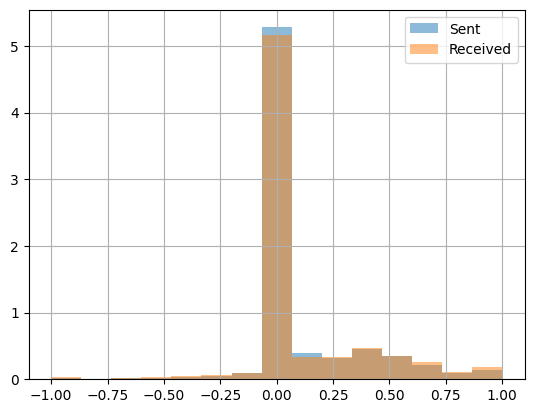

In [10]:
send_df = df[df['from_id']==MY_UID]
recv_df = df[df['to_id']==MY_UID]
send_df.tone_normalized.hist(bins=15, alpha=0.5, density=True, label='Sent')
recv_df.tone_normalized.hist(bins=15, alpha=0.5, density=True, label='Received')
plt.legend()

## 1.2 What are the distribution of message tones accross groups?

<Axes: >

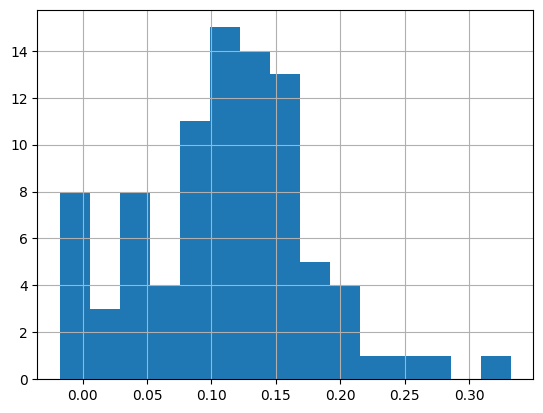

In [11]:
df[df['dialog_type'] == 'Group'].groupby('dialog_id')['tone_normalized'].mean().hist(bins=15)

## 1.3 What are the average tone of messages for different groups?

<Axes: xlabel='dialog_id'>

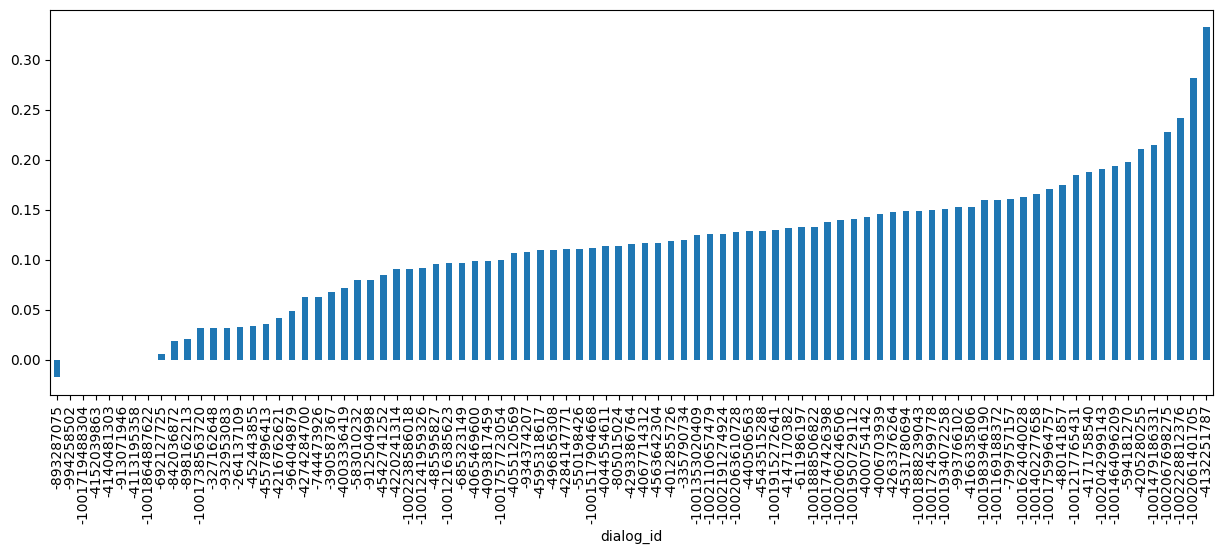

In [12]:
plt.figure(figsize=(15, 5))
df[df['dialog_type'] == 'Group'].groupby('dialog_id')['tone_normalized'].mean().sort_values().plot(kind='bar')

# 2. Topic Modeling

Here we aggregated the messages by dialog and day. Then performed HDBSCAN clusterization to identify the clusters (topics)

In [13]:
df_ = (
    df.groupby(['dialog_id', 'date'])
    .agg({
        'message_proc': lambda messages: ' '.join(messages),
        'tone': 'sum',
        'tone_normalized': 'mean',
        'word2vec': lambda vectors: np.mean(np.stack(vectors), axis=0),
        'from_id': 'count'
    })
    .reset_index()
    .rename(columns={'from_id': 'message_count'})
)

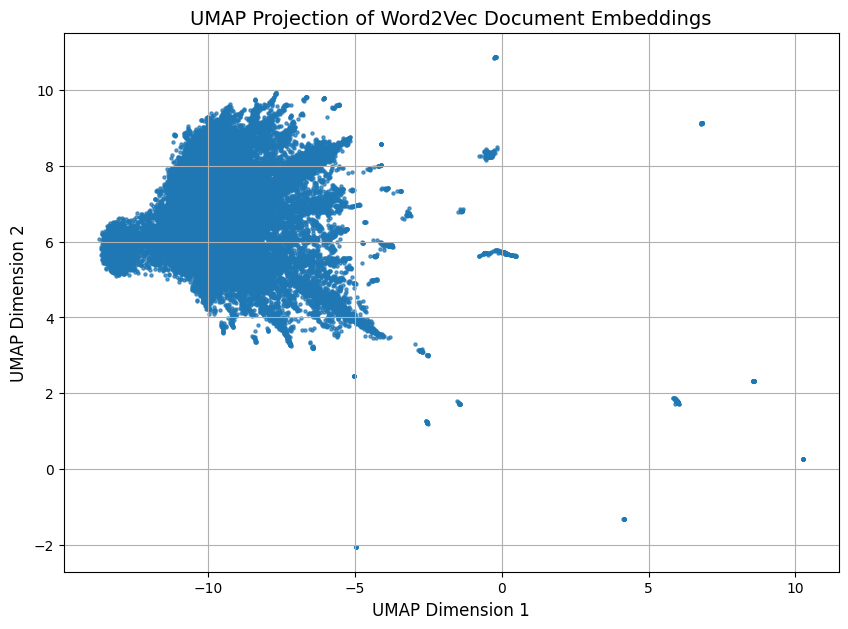

In [14]:
document_vectors = np.vstack(df_['word2vec'].values)
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', n_components=2)
reduced_vectors_umap = umap_reducer.fit_transform(document_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_vectors_umap[:, 0], reduced_vectors_umap[:, 1], s=5, alpha=0.7)
plt.title("UMAP Projection of Word2Vec Document Embeddings", fontsize=14)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True)
plt.show()

In [15]:
document_vectors = np.vstack(df_['word2vec'].values)

hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10, 
    min_samples=3,       
    cluster_selection_epsilon=0.005, 
    core_dist_n_jobs=-1
)
clusters = hdbscan_clusterer.fit_predict(document_vectors)

df_['cluster'] = clusters

cluster_common_words = {}
for cluster_id in sorted(df_['cluster'].unique()):
    if cluster_id == -1:
        continue
    cluster_messages = ' '.join(df_.loc[df_['cluster'] == cluster_id, 'message_proc'].tolist())
    word_counts = Counter(cluster_messages.split())
    cluster_common_words[cluster_id] = word_counts.most_common(100)

for cluster_id, common_words in cluster_common_words.items():
    print(f"Cluster {cluster_id}:")
    for word, count in common_words:
        print(f"  {word}: {count}")
    print()

Cluster 0:
  перекличка: 12

Cluster 1:
  👋: 15

Cluster 2:
  жк: 44
  avalon: 44
  prime: 44
  хід: 43
  будівництва: 43
  будинок: 43
  новини: 17
  🔸оновили: 17
  дивитись: 17
  деталі: 17
  фото🔸: 16
  збудовано: 15
  лютий: 3
  березень: 3
  квітень: 3
  травень: 3
  червень: 3
  липень: 3
  серпень: 3
  жовтень: 2
  листопад: 2
  грудень: 2
  будується: 1
  характеристики🔸: 1
  поверховість: 1

Cluster 3:
  новим: 22
  роком: 22
  🥳🥳🥳: 9
  сонце😚❤️: 1
  ✨✨✨: 1
  🎄🎄🎄: 1

Cluster 4:
  👋: 16
  митник: 3
  ставши: 3
  найбільший: 3
  набір: 2
  алгоритм: 2
  маємо: 2
  розглянути: 2
  якись: 2
  фарисей: 2
  боже: 2
  царстві: 2
  покликав: 2
  бувши: 2
  смерти: 2
  дорозі: 2
  знайшов: 1
  відео: 1
  розбирати: 1
  штука: 1
  айфонах: 1
  працює: 1
  🤓: 1
  опис: 1
  написав: 1
  ростислав: 1
  схоже: 1
  даних: 1
  результатів: 1
  правильно: 1
  зрозумів: 1
  обрати: 1
  проблему: 1
  вирішує: 1
  разом: 1
  придумати: 1
  задачу: 1
  вирішувати: 1
  розумію: 1
  вибір: 1
  вільн

- Cluster 0 and 1: Looks like outliers
- Cluster 2: Is the topic of real estate announcements
- Cluster 3: Is the greetings with New Year
- Cluster 4: Is a mix of many topics
- Cluster 5: Is the topic of IT job offerings
- Cluster 6: Is the topic of Ukrainian startups
- Cluster 7: Is another topic of IT job offerings

# 3. Messages activity

## 3.1. What is my activity during the day?

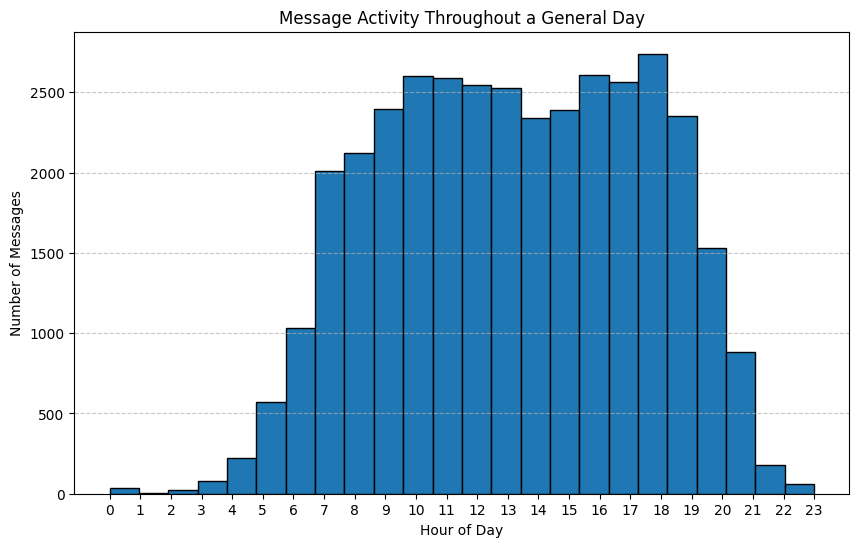

In [16]:
sent_df = df[df['from_id'] == MY_UID].copy()
sent_df['day_of_week'] = sent_df['date_time'].dt.day_name()
sent_df['hour'] = sent_df['date_time'].dt.hour

plt.figure(figsize=(10, 6))
plt.hist(sent_df['hour'], bins=24, range=(0, 23), edgecolor='black')
plt.title('Message Activity Throughout a General Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2 What is my activity for each day of week?

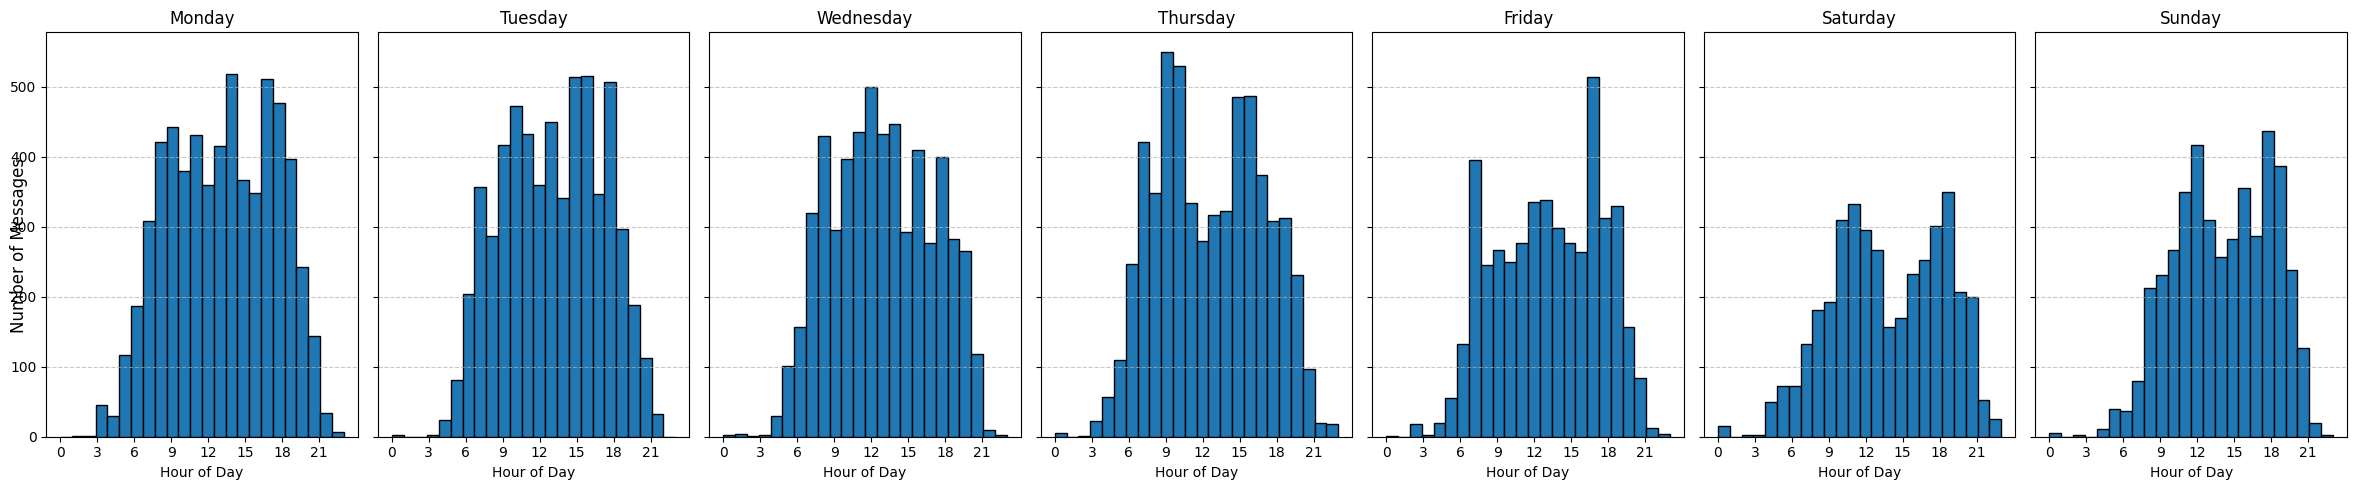

In [17]:
sent_df = df[df['from_id'] == MY_UID].copy()
sent_df['day_of_week'] = sent_df['date_time'].dt.day_name()
sent_df['hour'] = sent_df['date_time'].dt.hour

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, axes = plt.subplots(1, 7, figsize=(24, 5), sharey=True)

for ax, day in zip(axes, day_order):
    day_data = sent_df[sent_df['day_of_week'] == day]['hour']
    ax.hist(day_data, bins=24, range=(0, 23), edgecolor='black')
    ax.set_title(day)
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(range(0, 24, 3))
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.supylabel('Number of Messages', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Recognize the interlocutors’ genders

Here we used `gender_guesser` library to create rough ground truth. Then we have thrown out data points of unidentified genders and balanced classes by undersampling (oversampling didn't work well). Then we trained the Random Forest Classifier to predict gender based on message text.

In [18]:
d = gender.Detector()
df_ = df.copy()
df_ = df_[df_['from_id'] != MY_UID]
df_ = df[df['dialog_type'] == 'Private dialog']
df_ = df_[df_['name'].isna() == False]

def guess_gender(full_name):
    name_parts = full_name.split()
    genders = [d.get_gender(part) for part in name_parts]
    normalized_genders = [g.replace('mostly_female', 'female').replace('mostly_male', 'male') for g in genders if g != 'unknown']
    if not normalized_genders:
        return 'unknown'
    most_common_gender = Counter(normalized_genders).most_common(1)
    return most_common_gender[0][0] if most_common_gender else 'unknown'  # Default to 'unknown' if no gender

df_['guessed_gender'] = df_['name'].apply(guess_gender)
df_ = df_[df_['guessed_gender'] != 'unknown']
df_ = df_[df_['message'].str.len() > 0]

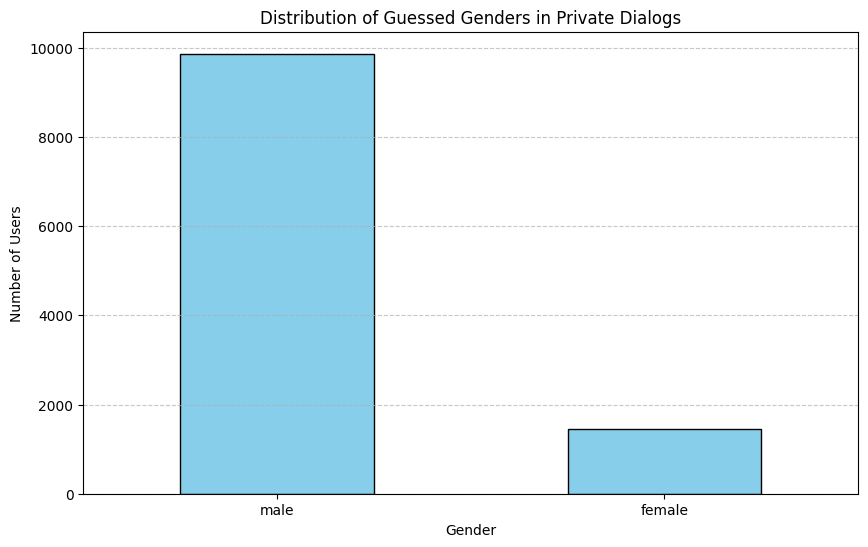

In [19]:
gender_counts = df_['guessed_gender'].value_counts()
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of Guessed Genders in Private Dialogs')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
corpus = df_['message'].str.split().tolist()
w2v_model = Word2Vec(sentences=corpus, vector_size=128, window=5, min_count=1, workers=-1, sg=1)
df_['word2vec_vector'] = df_['message'].str.split().apply(lambda x: compute_document_embedding(x, w2v_model))

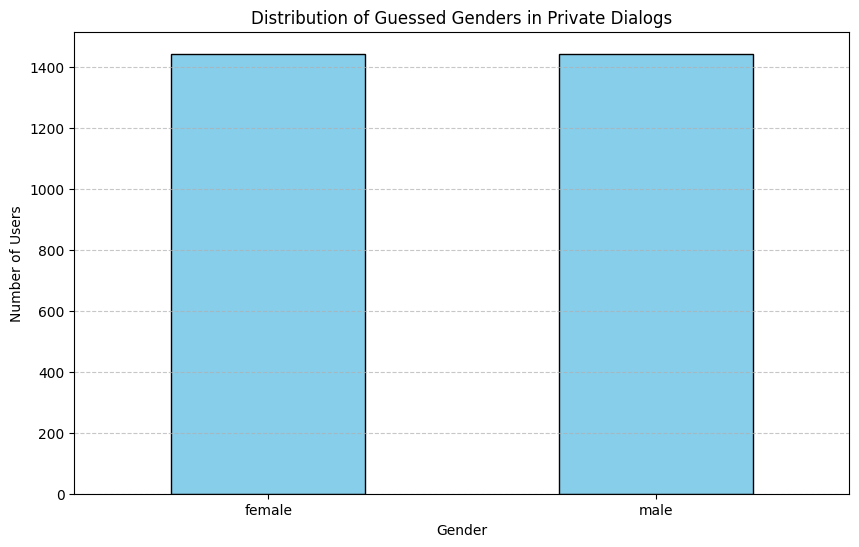

In [21]:
X = np.vstack(df_['word2vec_vector'].values)
y = df_['guessed_gender']

sampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
X, y = sampler.fit_resample(X, y)

gender_counts = y.value_counts()
gender_counts.plot(kind='bar', color='skyblue', edgecolor='black', figsize=(10, 6))
plt.title('Distribution of Guessed Genders in Private Dialogs')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5622837370242214

Classification Report:
               precision    recall  f1-score   support

      female       0.57      0.49      0.53       289
        male       0.55      0.63      0.59       289

    accuracy                           0.56       578
   macro avg       0.56      0.56      0.56       578
weighted avg       0.56      0.56      0.56       578



In [23]:
new_message = "Cонце!".split()
new_message_embedding = compute_document_embedding(new_message, w2v_model).reshape(1, -1)
predicted_gender = model.predict(new_message_embedding)
print("Predicted Gender:", predicted_gender[0])

Predicted Gender: female


In [24]:
new_message = "Привіт!".split()
new_message_embedding = compute_document_embedding(new_message, w2v_model).reshape(1, -1)
predicted_gender = model.predict(new_message_embedding)
print("Predicted Gender:", predicted_gender[0])

Predicted Gender: male


# 5. What is the distribution of languages?

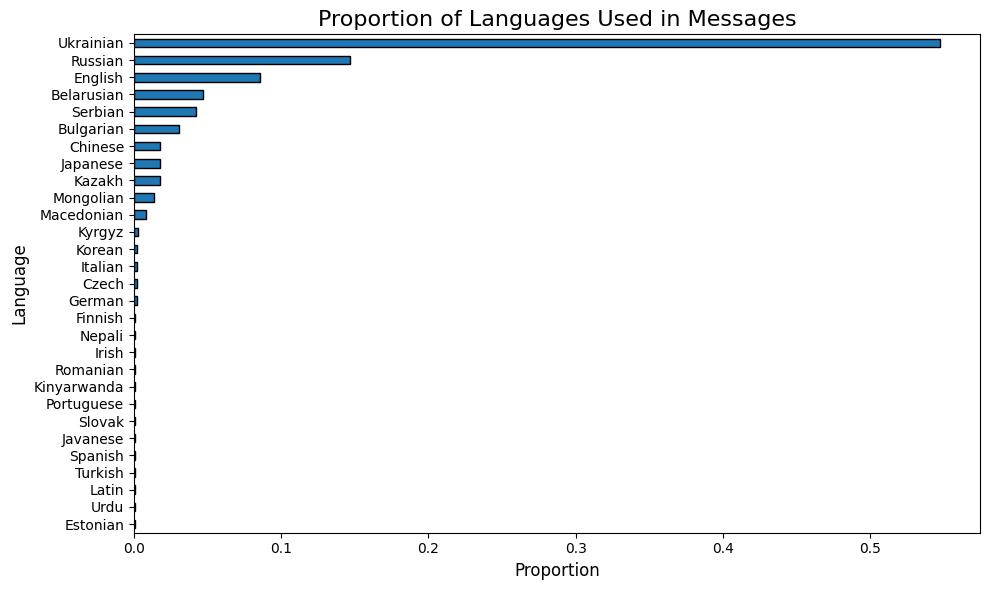

In [25]:
identifier = LanguageIdentifier.from_modelstring(lang_model, norm_probs=True)
df_ = df[['message']].dropna().sample(1000).copy()

def detect_language(text):
    try:
        lang, prob = identifier.classify(text)
        return lang
    except Exception:
        return "unknown"

df_['language'] = df_['message'].apply(detect_language)

threshold = 0.001
language_counts = df_['language'].value_counts(normalize=True)
frequent_languages = language_counts[language_counts >= threshold]
other_languages = language_counts[language_counts < threshold].sum()

if other_languages > 0:
    frequent_languages['Others'] = other_languages

def get_language_name(code):
    try:
        return langcodes.get(code).language_name()
    except LookupError:
        return code 

frequent_languages.index = [get_language_name(lang) for lang in frequent_languages.index]

plt.figure(figsize=(10, 6))
frequent_languages.sort_values().plot(
    kind='barh',
    colormap='tab10',
    edgecolor='black'
)
plt.title('Proportion of Languages Used in Messages', fontsize=16)
plt.xlabel('Proportion', fontsize=12)
plt.ylabel('Language', fontsize=12)
plt.tight_layout()
plt.show()